#pip install


In [ ]:
!pip install keras_self_attention tensorflow opencv-python pillow albumentations

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=cdc1bdc2bd678ed5aa0becb44e885ba690f55f550e64f0feab2d51878ab3b0b2
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


#imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, Dropout, LSTM, Dense, Input
from tensorflow.keras.models import Model

import numpy as np
import os
import cv2
import zipfile
import io
from collections import defaultdict
from PIL import Image

from albumentations import (
    Compose, RandomRotate90, Flip, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion,
    HueSaturationValue, RandomBrightnessContrast, MotionBlur, MedianBlur, GaussianBlur, CLAHE, RandomFog
)
from albumentations.core.composition import OneOf


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


#Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/final_vimm/

/content/drive/.shortcut-targets-by-id/1KxofV_oM8w2NmxTacMyOvOa1MjeLeaOS/final_vimm


In [ ]:
base_path = '/content/drive/MyDrive/final_vimm/'

#Load Data

In [ ]:
gun_will_appear_path = 'frames_final/gun_will_appear'
no_gun_path = 'frames_final/no_gun'

In [ ]:
train_path = 'train_all.zip'
test_path = 'test_all.zip'
categories = ['no_gun', 'gun_will_appear']
batch_size = 8

In [ ]:


def compute_max_sequence_length(zip_path, categories):
    max_sequence_length = 0

    with zipfile.ZipFile(zip_path, 'r') as z:
        for category in categories:
            path = category + '/'
            video_frames = defaultdict(list)
            for frame in sorted([f for f in z.namelist() if f.startswith(path)]):
                print(frame)
                video_id = "_".join(os.path.basename(frame).split('_')[:-1])
                video_frames[video_id].append(frame)

            for video_id, frames in video_frames.items():
                max_sequence_length = max(max_sequence_length, len(frames))

    return max_sequence_length



max_sequence_length_train = compute_max_sequence_length(train_path, categories)
max_sequence_length_test = compute_max_sequence_length(test_path, categories)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)


no_gun/
gun_will_appear/
no_gun/
gun_will_appear/


#Classes Definition (Dataset + F1Score)

In [ ]:



class VideoFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, zip_path, folder_name, categories, img_size=(64, 64), batch_size=1, max_duration=5, frame_rate=24):
        self.zip_path = zip_path
        self.folder_name = folder_name
        self.categories = categories
        self.img_size = img_size
        self.batch_size = batch_size
        self.max_sequence_length = min(max_duration * frame_rate, max_sequence_length)
        self.valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

        self.zip_file = zipfile.ZipFile(self.zip_path, 'r')

        self.data = []
        self.labels = []
        for category, class_num in categories.items():
            path = os.path.join(folder_name, category)

            video_frames = defaultdict(list)
            for frame in sorted([f for f in self.zip_file.namelist() if f.startswith(path) and os.path.splitext(f)[1].lower() in self.valid_image_extensions]):  # Ensure frames are in correct order and are valid images
                video_id = "_".join(frame.split('/')[-1].split('_')[:-1])
                video_frames[video_id].append(frame)

            for video_id, frames in video_frames.items():
                if len(frames) > self.max_sequence_length:
                    frames = frames[:self.max_sequence_length]
                self.data.append((category, frames))
                self.labels.append(class_num)

        self.labels = np.array(self.labels)
        self.labels = to_categorical(self.labels, num_classes=len(categories))

    def get_augmentation_pipeline(self):
        return Compose([
            RandomRotate90(),
            Flip(),
            Transpose(),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            OneOf([
                MotionBlur(p=0.2),
                MedianBlur(blur_limit=(3, 5), p=0.1),
                GaussianBlur(blur_limit=(3, 5), p=0.1),
                Blur(blur_limit=(3, 5), p=0.1),
            ], p=0.3),
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            HueSaturationValue(p=0.3),
            RandomBrightnessContrast(p=0.3),
            CLAHE(p=0.3),
            RandomFog(p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        X_batch = []
        for category, frames in batch_data:
            video_data = []
            for frame in frames:
                with self.zip_file.open(frame) as img_file:
                    try:
                        img_file = io.BytesIO(img_file.read())
                        img = Image.open(img_file)
                        img = img.convert("RGB")
                        img = img.resize(self.img_size)
                        img_array = img_to_array(img)
                        if np.isnan(img_array).any() or np.isinf(img_array).any():
                            raise ValueError("NaNs or Infs found in image data")
                        img_array = img_array.astype('uint8')

                        img_array = self.get_augmentation_pipeline()(image=img_array)['image']

                        img_array = img_array.astype('float32') / 255.0

                        video_data.append(img_array)
                    except Exception as e:
                        print(f"Error loading image {frame}: {e}")
                        continue
            padded_video_data = tf.keras.preprocessing.sequence.pad_sequences(
                [video_data], maxlen=self.max_sequence_length, padding='post', dtype='float32')[0]
            X_batch.append(padded_video_data)

        X_batch = np.array(X_batch)
        batch_labels = np.array(batch_labels)

        return X_batch, batch_labels

class CustomF1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(CustomF1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)

        tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        for var in self.variables:
            var.assign(0)

#Model (MobileNet + TD + LSTM + Dropout)

In [ ]:

base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = True

video_input = Input(shape=(max_sequence_length, 64, 64, 3))

x = TimeDistributed(base_model)(video_input)
x = TimeDistributed(GlobalAveragePooling2D())(x)
x = TimeDistributed(Dropout(0.5))(x)

x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)  # Adjust output layer for the number of categories

model = Model(inputs=video_input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[CustomF1Score(), tf.keras.metrics.BinaryAccuracy()])



In [ ]:
train_generator = VideoFrameGenerator('train_all.zip', 'train_all', categories, batch_size=2)
val_generator = VideoFrameGenerator('test_all.zip','test_all', categories, batch_size=2)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)




Epoch 1/10
21/21 [==============================] - 68s 3s/step - loss: 0.5040 - f1_score: 0.8767 - binary_accuracy: 0.7805 - val_loss: 0.4940 - val_f1_score: 0.9000 - val_binary_accuracy: 0.8182
Epoch 2/10
21/21 [==============================] - 63s 3s/step - loss: 0.4982 - f1_score: 0.9041 - binary_accuracy: 0.8293 - val_loss: 0.5161 - val_f1_score: 0.9000 - val_binary_accuracy: 0.8182
Epoch 3/10
21/21 [==============================] - 63s 3s/step - loss: 0.5354 - f1_score: 0.8919 - binary_accuracy: 0.8049 - val_loss: 0.4963 - val_f1_score: 0.9000 - val_binary_accuracy: 0.8182
Epoch 4/10
21/21 [==============================] - 63s 3s/step - loss: 0.5859 - f1_score: 0.8767 - binary_accuracy: 0.7805 - val_loss: 0.4993 - val_f1_score: 0.9000 - val_binary_accuracy: 0.8182
Epoch 5/10
21/21 [==============================] - 63s 3s/step - loss: 0.6053 - f1_score: 0.8451 - binary_accuracy: 0.7317 - val_loss: 0.4798 - val_f1_score: 0.9000 - val_binary_accuracy: 0.8182
Epoch 6/10
21/21 [==

In [ ]:
# Save the model
model.save('gun_prediction_model_with_MOBILENET.h5')

#Model (EfficientNet + TD + LSTM + Dropout)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, Dropout, LSTM, Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf

base_model = EfficientNetB0(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = True

video_input = Input(shape=(max_sequence_length, 64, 64, 3))

x = TimeDistributed(base_model)(video_input)
x = TimeDistributed(GlobalAveragePooling2D())(x)
x = TimeDistributed(Dropout(0.5))(x)

x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=video_input, outputs=output)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[CustomF1Score(), tf.keras.metrics.BinaryAccuracy()])


In [ ]:
train_generator = VideoFrameGenerator('train_all.zip', 'train_all', categories, batch_size=2)
val_generator = VideoFrameGenerator('test_all.zip','test_all', categories, batch_size=2)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

model.save('gun_prediction_model_with_EFFNET.h5')


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.6818 - f1_score: 0.7333 - binary_accuracy: 0.6098

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric CustomF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


21/21 [==============================] - 104s 3s/step - loss: 0.6818 - f1_score: 0.7333 - binary_accuracy: 0.6098 - val_loss: 0.9275 - val_f1_score: 0.0000e+00 - val_binary_accuracy: 0.1818
Epoch 2/20
21/21 [==============================] - 64s 3s/step - loss: 0.5913 - f1_score: 0.8065 - binary_accuracy: 0.7073 - val_loss: 0.7876 - val_f1_score: 0.0000e+00 - val_binary_accuracy: 0.1818
Epoch 3/20
21/21 [==============================] - 64s 3s/step - loss: 0.6197 - f1_score: 0.7692 - binary_accuracy: 0.6341 - val_loss: 0.7554 - val_f1_score: 0.0000e+00 - val_binary_accuracy: 0.1818
Epoch 4/20
21/21 [==============================] - 63s 3s/step - loss: 0.5719 - f1_score: 0.8308 - binary_accuracy: 0.7317 - val_loss: 0.7658 - val_f1_score: 0.3636 - val_binary_accuracy: 0.3636
Epoch 5/20
21/21 [==============================] - 64s 3s/step - loss: 0.5279 - f1_score: 0.8657 - binary_accuracy: 0.7805 - val_loss: 0.6606 - val_f1_score: 0.8750 - val_binary_accuracy: 0.8182
Epoch 6/20
21/21 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Augmentation EXAMPLE

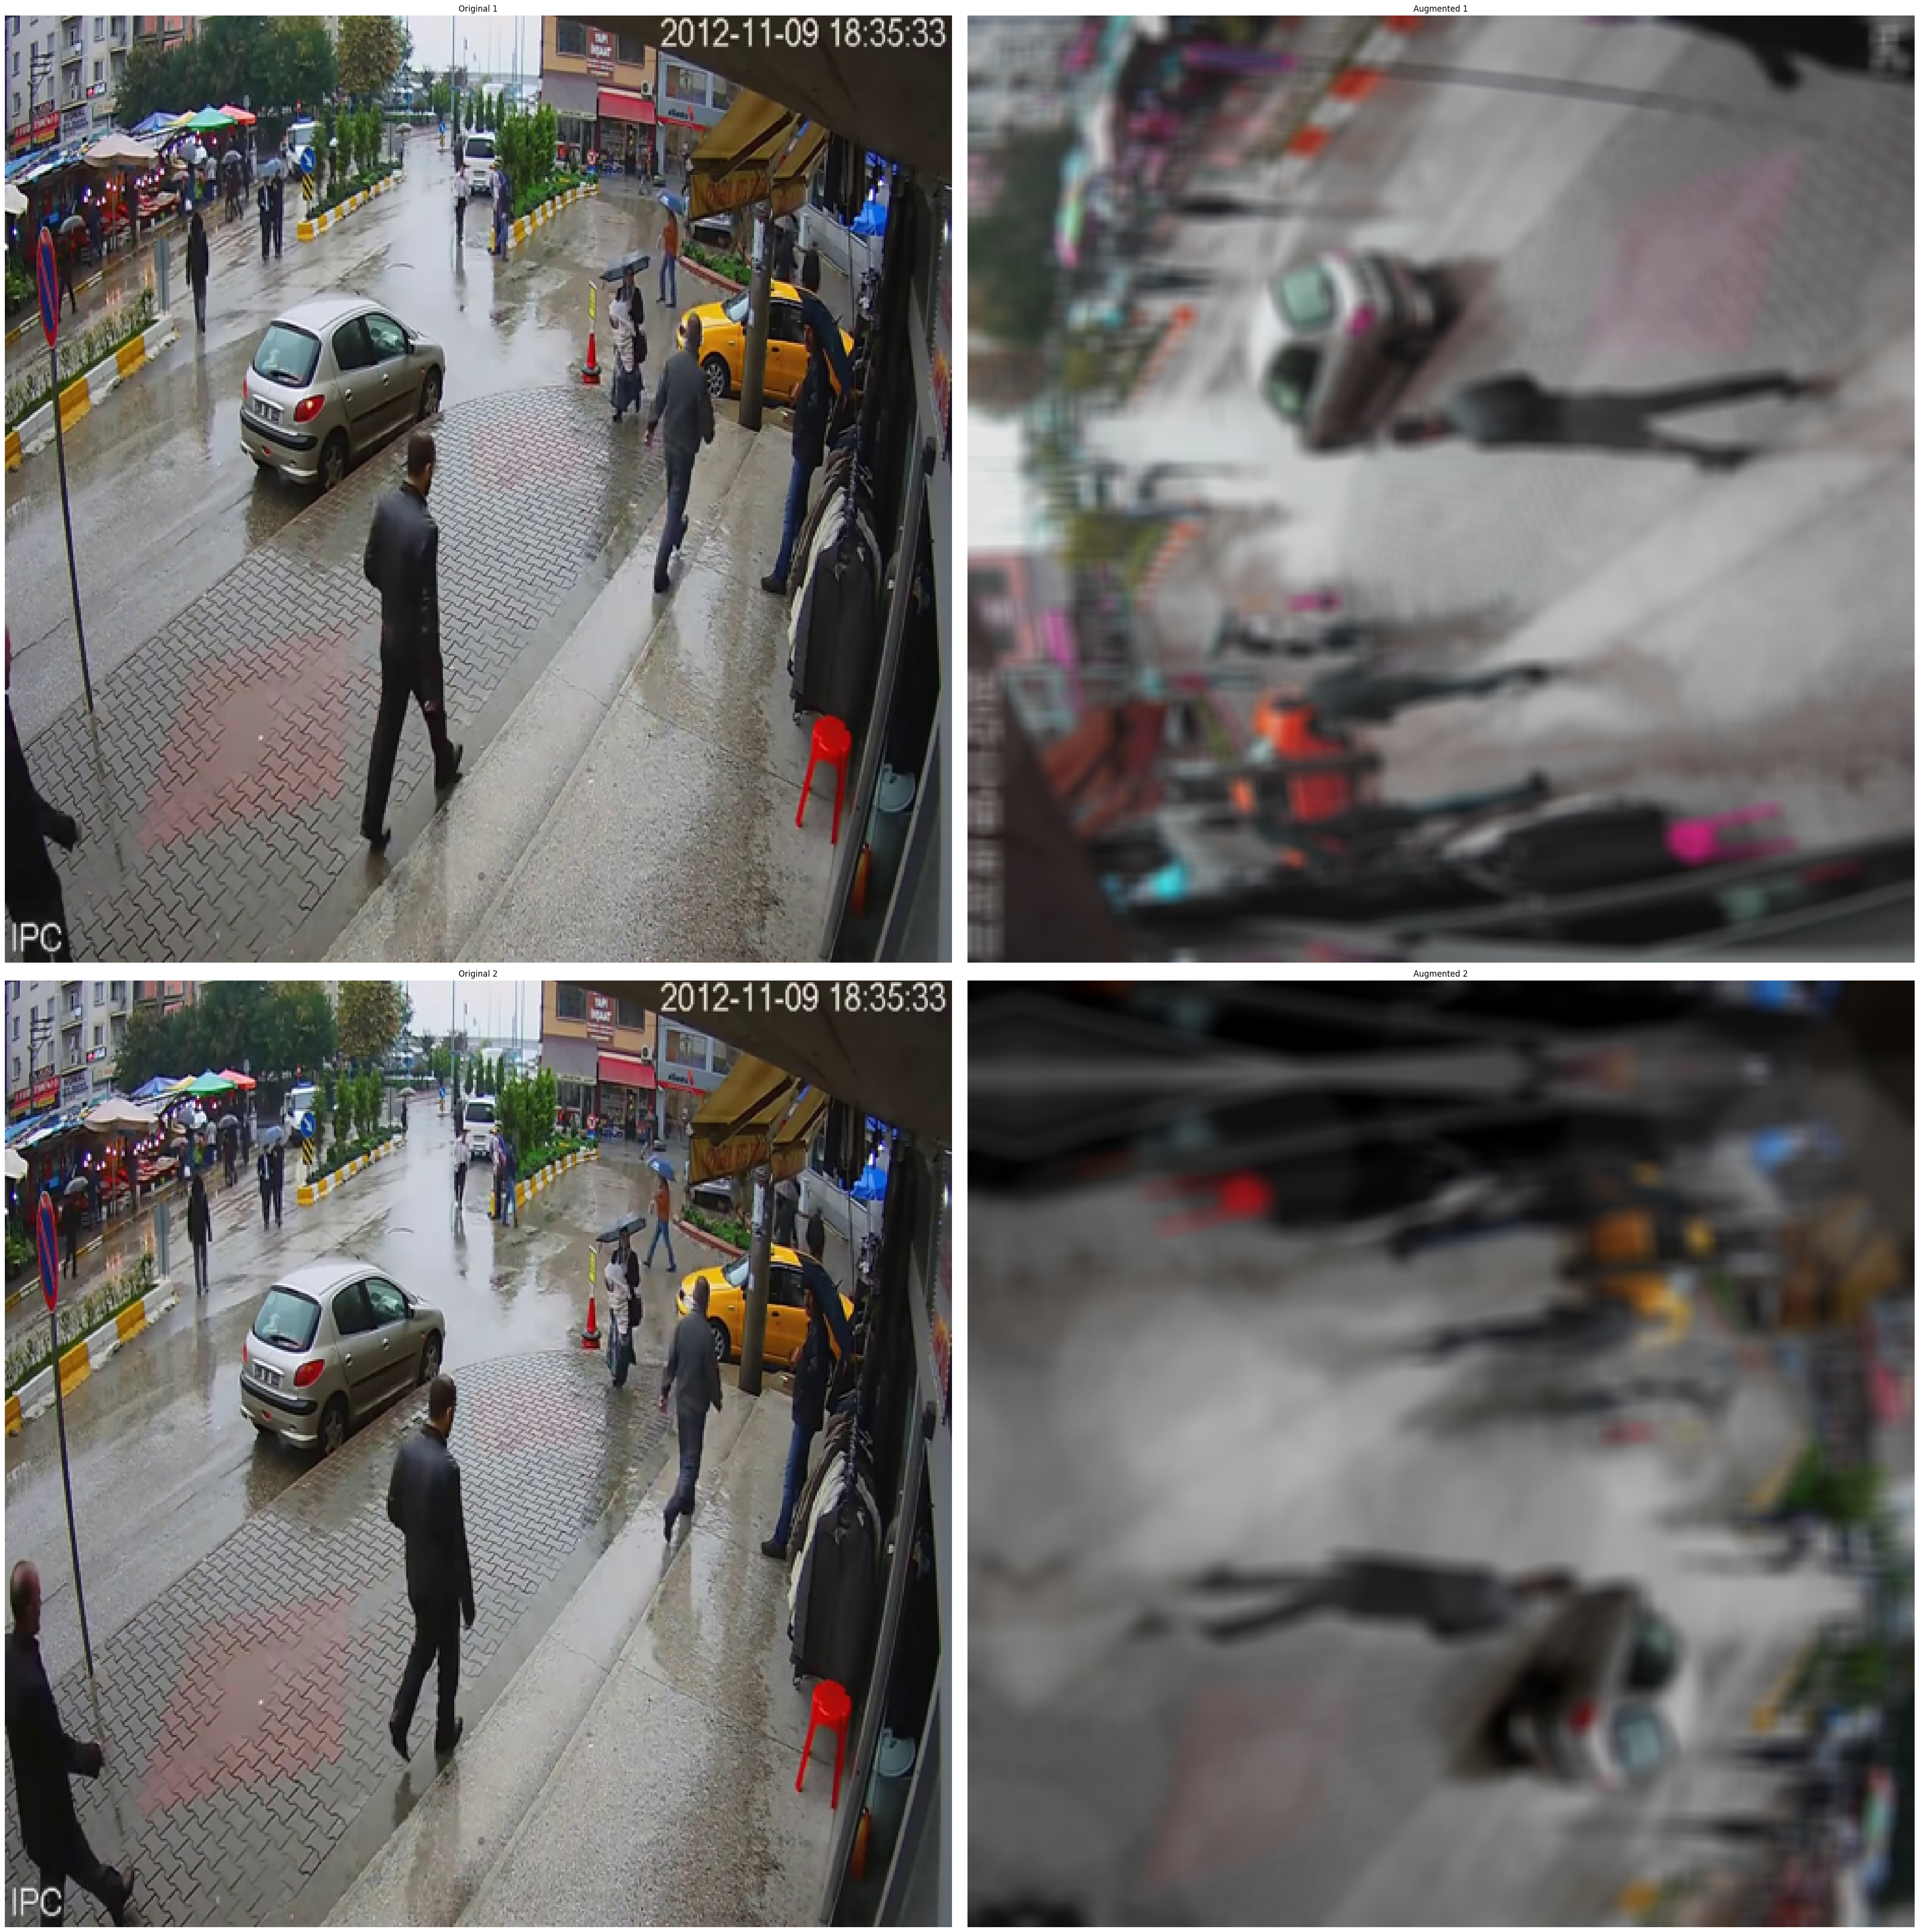

In [ ]:
#Augmentation EXAMPLE